# Figure 04. Absolute effect size of susceptibility associated variants

by frequency

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'ggh4x'

The following object is masked from 'package:ggplot2':

    guide_axis_logticks

In [ ]:

source("bin/outs.R")



Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

here() starts at /Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript

$strain_table
$strain_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.html"

$strain_table$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.tsv.zip"

$strain_table$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.docx"

$strain_table$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.csv"


$tox_table_ft
$tox_table_ft$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.html"

$tox_table_ft$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.tsv.zip"

$tox_table_ft$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.docx"

$tox_table_ft$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.csv"


$trait_table
$trait_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S3/table_S3.html"

$trait_table$tsv
[1] "

In [ ]:

# Load the tox data for condition metadata
tox <- data.table::fread(tox_meta_fn) %>%
  dplyr::filter(type == "Toxicant") %>%
  dplyr::select(trait, nice_drug_label2, big_class) %>%
  # adjust the uM to µM
  dplyr::mutate(nice_drug_label2 = dplyr::case_when(
    nice_drug_label2 == "uM" ~ "µM",
    TRUE ~ nice_drug_label2
  ))

# Load all mapping files
all.mappings_inbred <- list.files(
  path = glue::glue("{ns_folder}/INBRED/Mapping/Processed"),
  pattern = "AGGREGATE_mapping_inbred",
  recursive = TRUE,
  full.names = TRUE
)

# read in all the mappings
inbred.mapping.results <- purrr::map(all.mappings_inbred, combine.mappings) %>%
  Reduce(rbind, .) %>%
  dplyr::mutate(var_type = stringr::str_extract(trait, pattern = "length|CV_length")) %>%
  dplyr::filter(var_type != "CV_length") %>%
  dplyr::filter(trait != "length_water") %>%
  dplyr::filter(trait != "length_DMSO")

# get the drug classes
tox.QTL.summary <- inbred.mapping.results %>%
  dplyr::select(marker, trait, log10p, BETA, AF1, var.exp, algorithm) %>%
  dplyr::distinct() %>%
  dplyr::left_join(., tox, by = c("trait" = "trait"))

# setup just for the length trait in inbred algorithm
L.inbred <- tox.QTL.summary

# get a nice color pal
class.pal.df <- tibble::tibble(
  col = c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00"),
  big_class = c("Flame Retardant", "Fungicide", "Herbicide", "Insecticide", "Metal")
)

# get a nice color pal
col.pal <- class.pal.df$col
names(col.pal) <- class.pal.df$big_class


In [ ]:
tox.effect.bubble <- L.inbred %>%
  dplyr::mutate(
    big_class = factor(
      big_class,
      levels = c(
        "Flame Retardant",
        "Fungicide",
        "Herbicide",
        "Insecticide",
        "Metal"
      )
    )
  ) %>%
  ggplot(
    mapping = aes(
      y = abs(BETA),
      x = AF1
    )
  ) +
  geom_point(
    mapping = aes(
      fill = big_class,
      size = var.exp * 100
    ),
    shape = 21
  ) +
  stat_smooth(
    se = F,
    show.legend = F,
    span = 10,
    linetype = 2,
    color = "black",
    linewidth = 0.75,
    method = "nls",
    formula = y ~ a * exp(-b * x),
    method.args = list(start = list(a = 1, b = 1))
  ) +
  scale_fill_manual(values = col.pal) +
  guides(
    size = guide_legend(
      title = "Variation in susceptibility\nexplained by peak marker (%)",
      order = 2
    ),
    fill = guide_legend(
      title = "Toxicant class",
      order = 1,
      override.aes = list(
        size = 3
      )
    )
  ) +
  theme_bw() +
  labs(
    y = "Absolute effect size µm",
    x = "Frequency"
  )


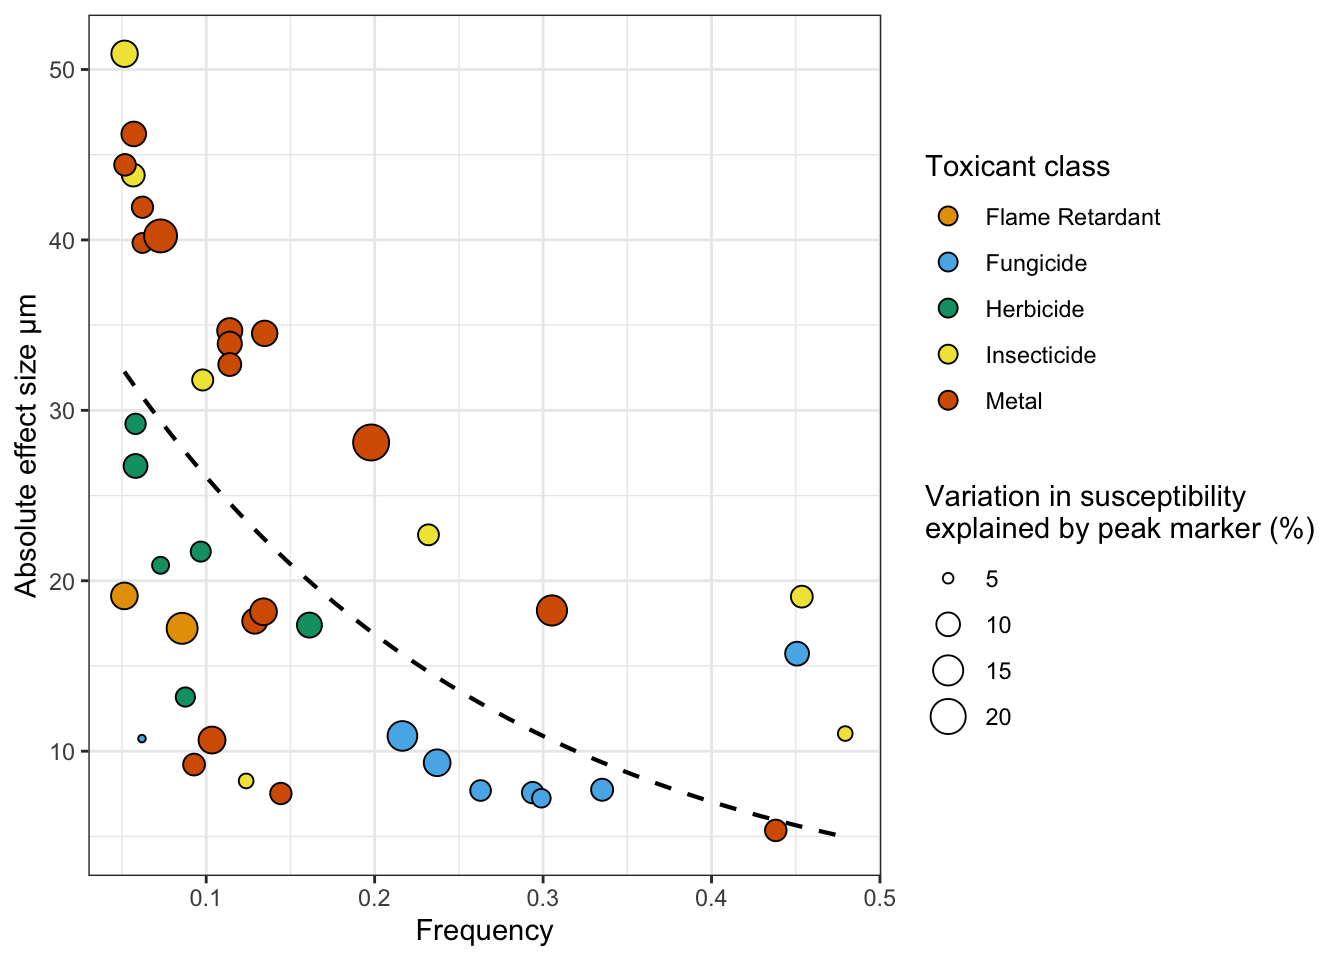

In [ ]:
tox.effect.bubble


In [ ]:
# Save the plot with appropriate dimensions

pub_figure <- tox.effect.bubble +
  theme(
    legend.position = c(0.95, 0.95),
    legend.justification = c("right", "top"),
    legend.direction = "vertical",
    panel.grid = element_blank(),
    legend.title = element_text(size = 9),
    legend.text = element_text(size = 8)
  )


3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.